# Demand forecasting

In [132]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.dataprocessing import transformers
from darts import models
from darts import metrics

import torch

from nyc_taxi.etl.psql_tools import TransactionManager

## Load time series for a specific location

In [2]:
def values_in_correct_intervals(df):
    fare_amount_correct = df['fare_amount'] > 2
    passenger_count_correct = df['passenger_count'] > 0
    trip_distance_correct = df['trip_distance'] > 0
    total_amount_correct = df['total_amount'] < 100
    duration_correct = df['lpep_dropoff_datetime'] > df['lpep_pickup_datetime']
    correct_rate = (df['trip_rate'] < 10) & (df['trip_rate'] > 0.5)
    
    return (fare_amount_correct & passenger_count_correct & trip_distance_correct & total_amount_correct & duration_correct & correct_rate)
    
    
def clean_dataset(df):
    return (
        df
        .assign(trip_rate=df['fare_amount'] / ((df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60.))
        .pipe(lambda df: df[values_in_correct_intervals(df)]))

In [67]:
selected_location_id = 74

green_taxi = TransactionManager().pd_read_psql(f"""
select lpep_pickup_datetime, fare_amount, passenger_count, trip_distance, total_amount, lpep_dropoff_datetime 
from green_taxi_records 
where pulocationid = {selected_location_id}
and lpep_pickup_datetime > '2016-07-01'
""")

In [68]:
green_taxi.shape

(2262060, 6)

In [69]:
%%time
clean_green_taxi = (
    green_taxi
    .assign(**{col: pd.to_datetime(green_taxi[col]) for col in ['lpep_dropoff_datetime', 'lpep_pickup_datetime']})
    .pipe(clean_dataset)
    .reset_index(drop=True)
)
clean_green_taxi.shape

CPU times: user 849 ms, sys: 61.5 ms, total: 911 ms
Wall time: 844 ms


(2203989, 7)

In [8]:
daily_demand = clean_green_taxi.groupby(clean_green_taxi['lpep_pickup_datetime'].dt.date).size().reset_index().rename(columns={0: 'count'})

## Split the data to train, validation and test

In [192]:
series = TimeSeries.from_dataframe(daily_demand, 'lpep_pickup_datetime', 'count', freq='D')
train, val_test = series.split_after(pd.Timestamp('2018-10-01'))
val, test = val_test.split_after(pd.Timestamp('2018-11-01'))

transformer = transformers.Scaler()

train_transformed = transformer.fit_transform(train)
val_test_transformed = transformer.transform(val_test)
val_transformed = transformer.transform(val)
test_transformed = transformer.transform(test)
series_transformed = transformer.transform(series)

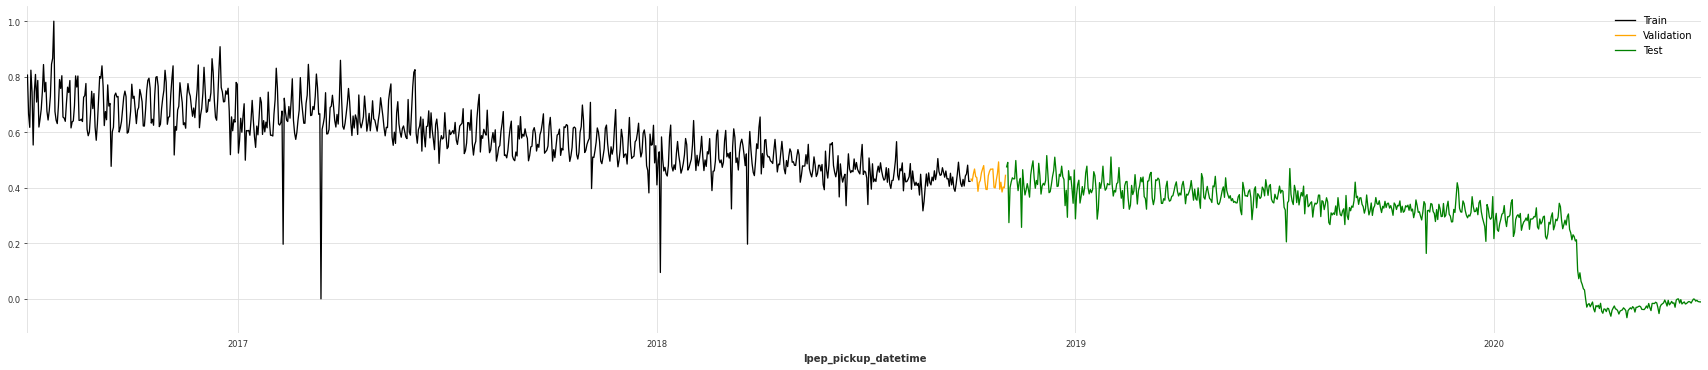

In [193]:
plt.figure(figsize=(30, 6))
train_transformed.plot(color='black', label='Train')
val_transformed.plot(color='orange', label='Validation')
test_transformed.plot(color='green', label='Test')
plt.legend();

## Train a couple of models

In [194]:
def evaluate_model(model, evaluation_ts_transformed, trans, figsize=(30, 5), title=''):
    predictions = trans.inverse_transform(model.predict(len(evaluation_ts_transformed)))
    ground_truth = trans.inverse_transform(evaluation_ts_transformed)
    
    score = metrics.rmse(predictions, ground_truth)
    
    plt.figure(figsize=figsize)
    plt.title(f'{title} RMSE: {score:.0f}')    
    ground_truth.plot(color='orange', label='Ground Truth')
    predictions.plot(color='steelblue', label='Prediction', linestyle='--')
    plt.ylabel('Number of pick ups per day')
    plt.xlabel('Day of pickups')
    plt.legend()

### Baseline: Copy last week values

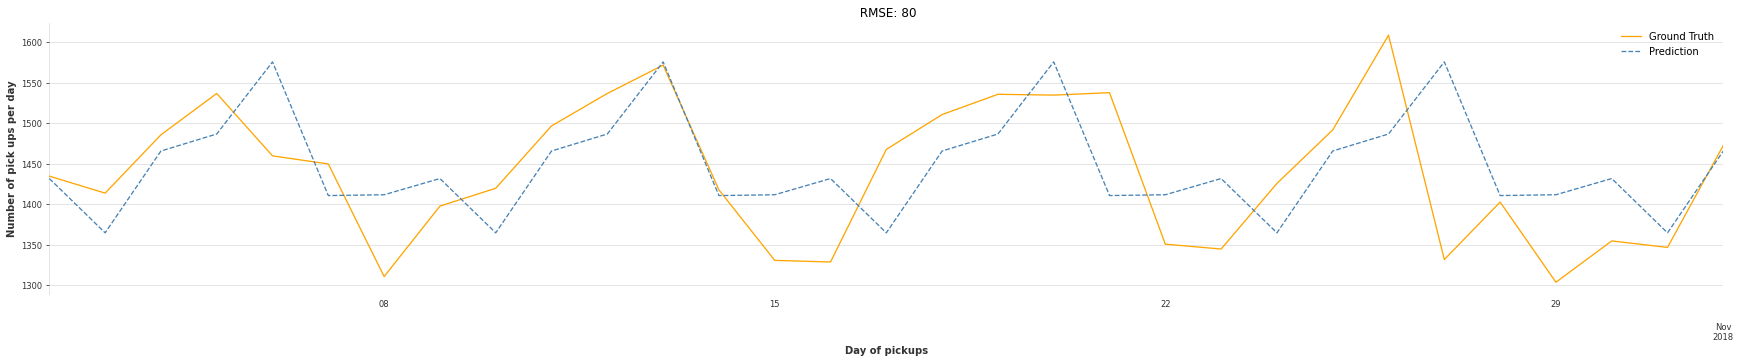

In [195]:
baseline_model = models.baselines.NaiveSeasonal(K=7)

baseline_model.fit(train_transformed)

evaluate_model(baseline_model, val_transformed, transformer)

### Prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


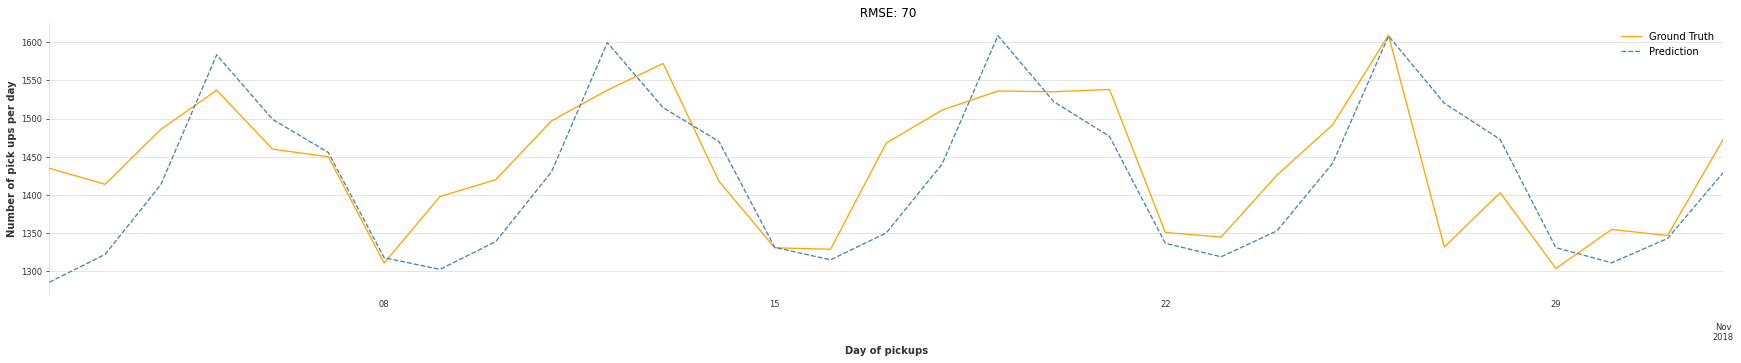

In [196]:
propeht_model = models.Prophet(country_holidays='US')

propeht_model.fit(train_transformed)

evaluate_model(propeht_model, val_transformed, transformer)

### Fast Fourier

/home/mariosk/.pyenv/versions/3.8.2/envs/kaggle-prostate/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
[2020-12-03 05:47:20,253] WARNING | darts.models.fft | No matching timestamp could be found, returning original TimeSeries.
[2020-12-03 05:47:20,253] WARNING | darts.models.fft | No matching timestamp could be found, returning original TimeSeries.


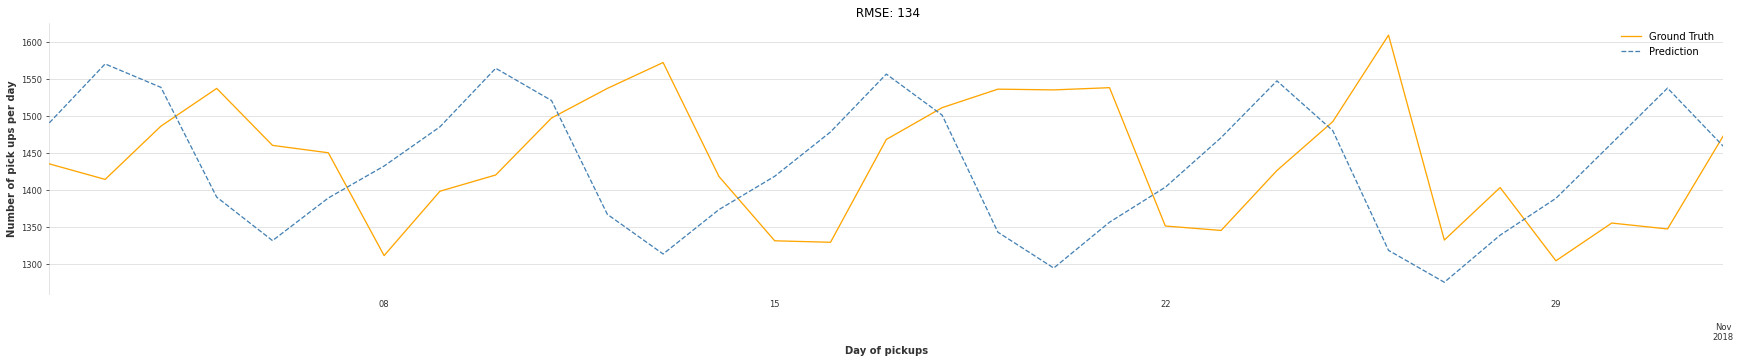

In [200]:
fft_model = models.fft.FFT(nr_freqs_to_keep=10, trend='poly')

fft_model.fit(train_transformed)

evaluate_model(fft_model, val_transformed, transformer)

### LSTM model

Training loss: 0.0016, validation loss: 0.0040


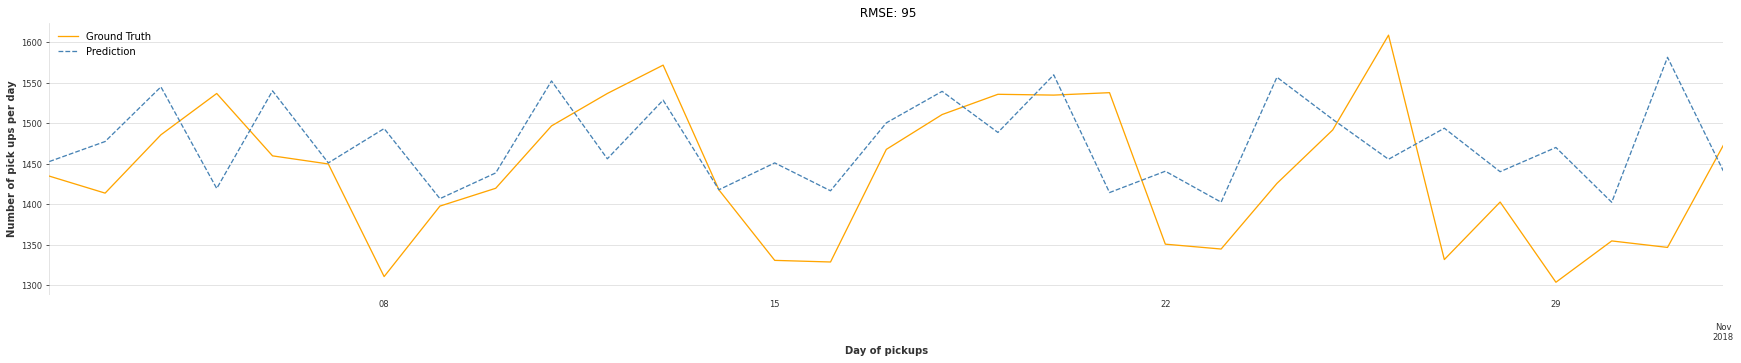

In [207]:
rnn_model = RNNModel(
    'LSTM', 
    input_length=14,
    output_length=14,
    n_rnn_layers=3,
    hidden_size=128,
    dropout=0.7,
    batch_size=8,
    n_epochs=500,
    optimizer_kwargs={'lr': 1e-3},
    log_tensorboard=True,
    work_dir='lstm_models'
)

rnn_model.fit(
    train_transformed, 
    val_training_series=val_transformed, 
    verbose=1)

evaluate_model(rnn_model, val_transformed, transformer)

## Predict on test set

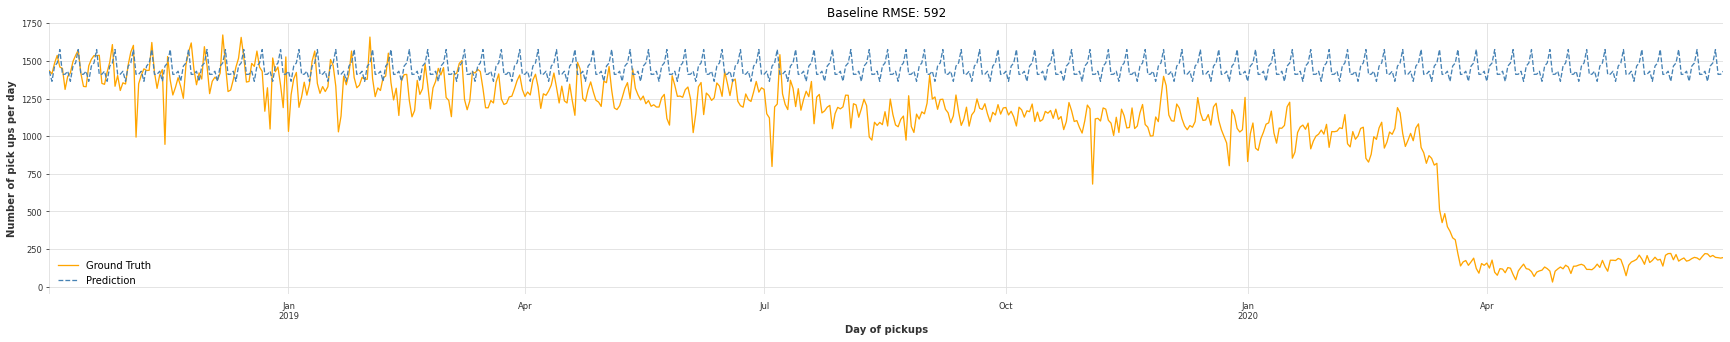

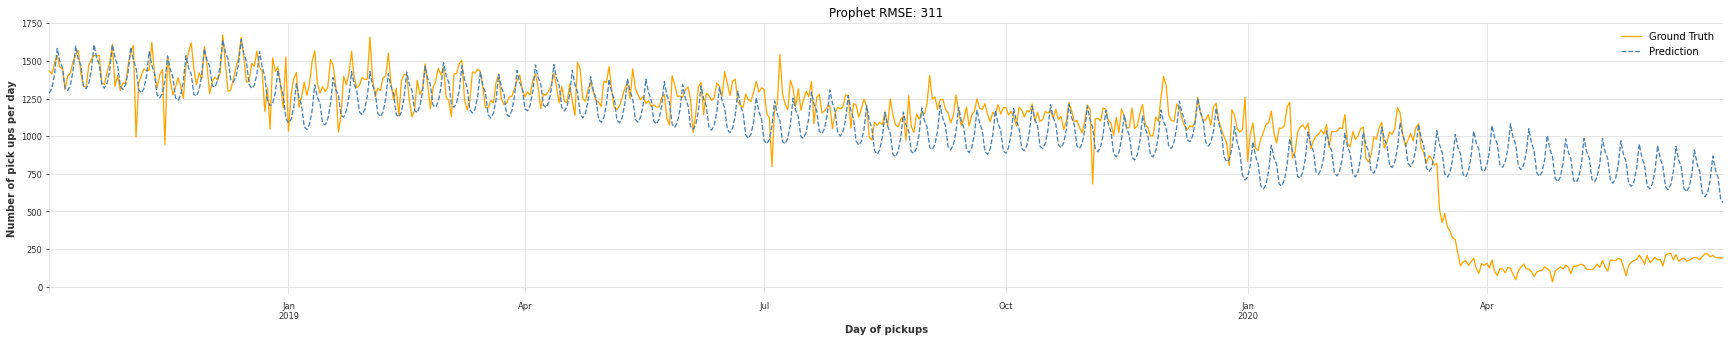

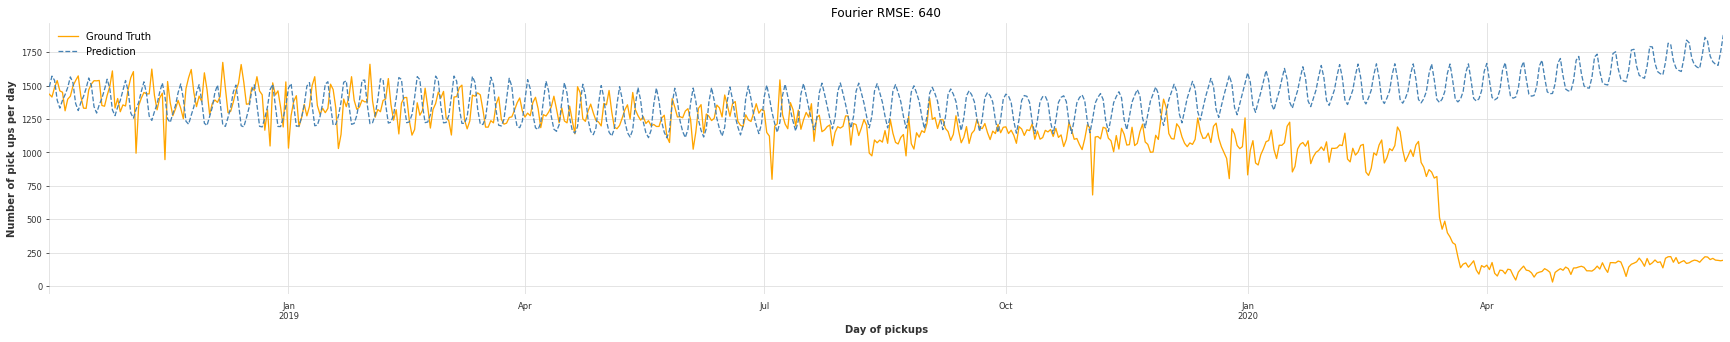

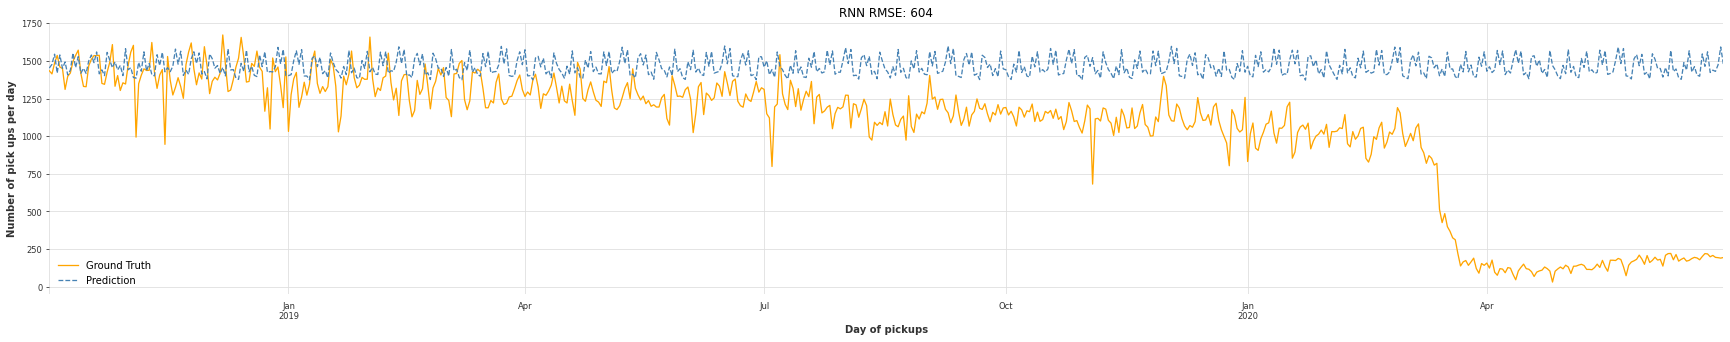

In [211]:
evaluate_model(baseline_model, val_test_transformed, transformer, title='Baseline')
evaluate_model(propeht_model, val_test_transformed, transformer, title='Prophet')
evaluate_model(fft_model, val_test_transformed, transformer, title='Fourier')
evaluate_model(rnn_model, val_test_transformed, transformer, title='RNN')